In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

%matplotlib inline

## 二分类问题
蘑菇是否有毒

### 模型基本运行
binary:logistic 二分类的逻辑回归，返回预测的概率(不是类别)。

In [2]:
# 数据读取
dtrain = xgb.DMatrix('agaricus.txt.train')
dtest = xgb.DMatrix('agaricus.txt.test')

# 设置参数
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eta': '0.2',
    'gamma': '1.0',
    'min_child_weight': 1,
    'max_depth': 5
}
# 训练轮数
num_round = 5

# 训练过程中加入实时输出评估结果
watchlist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, watchlist)

[00:46:25] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[00:46:25] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test
[0]	train-error:0.00061	test-error:0.00000
[1]	train-error:0.00123	test-error:0.00000
[2]	train-error:0.00061	test-error:0.00000
[3]	train-error:0.00061	test-error:0.00000
[4]	train-error:0.00000	test-error:0.00000


### 持久化模型与模型的加载

In [3]:
# 存储并重新加载模型并预测
model.save_model('./0002.model')
bst = xgb.Booster()
bst.load_model('./0002.model')
predict = bst.predict(dtest)

# 打印预测值
print(predict)
# 添加xgboost_agaricus_featmap.txt特征映射文件后，dump_model可更直接了当观察树模型
dump_model = bst.dump_model('./dump.raw.txt')
dump_model = bst.dump_model('./dump.nice.txt', './xgboost_agaricus_featmap.txt')

[0.17636333 0.82546127 0.17636333 ... 0.82546127 0.17495753 0.82546127]


### 可视化

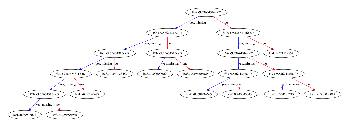

In [4]:
# 使用matplotlib绘制
xgb.plot_tree(model)

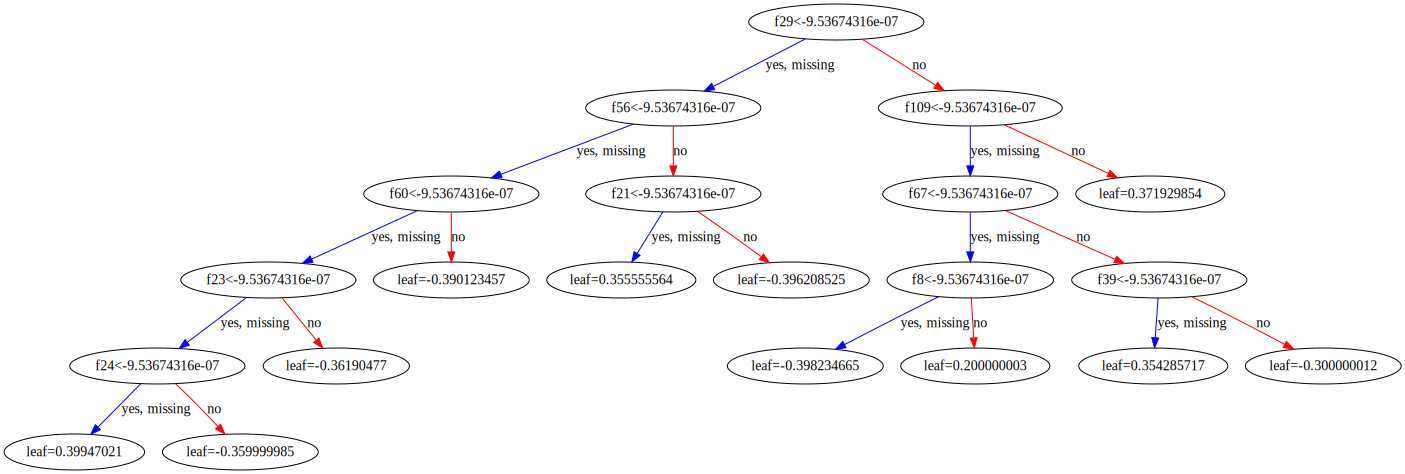

In [5]:
# 转化为graphviz
xgb.to_graphviz(model)

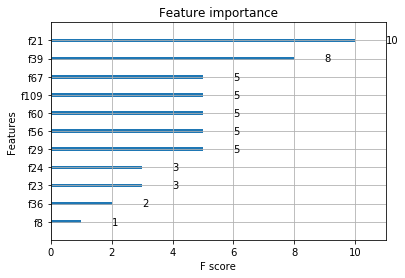

In [6]:
xgb.plot_importance(model)

## 多分类问题

- multi:softmax 使用softmax的多分类器，返回预测的类别(不是概率)
- multi:softprob 和multi:softmax参数一样，但是返回的是每个数据属于各个类别的概率

In [7]:
# 加载数据时候将7列-1且转化为小数
seeds_data = pd.read_csv('seeds_dataset.txt', sep='\s+', header=None, converters={7: lambda x: int(x)-1})
seeds_data.rename(columns={7: 'label'}, inplace=True)
seeds_data.head(5)

,0,1,2,3,4,5,6,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [8]:
# 以下三种类别，各70条
seeds_data['label'].value_counts()

2    70
1    70
0    70
Name: label, dtype: int64

In [9]:
# 切分训练与测试数据集
X_train, X_test, y_train, y_test = train_test_split(seeds_data.iloc[:,:7], seeds_data['label'], test_size=0.2, random_state=666)
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)


In [10]:
# 设置参数
params = {
    'objective': 'multi:softmax',
    'eta': '0.2',
    'max_depth': 5,
    'num_class': 3
}
# 训练轮数
num_round = 5

# 训练过程中加入实时输出评估结果
watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]
model = xgb.train(params, xgb_train, num_round, watchlist)

[0]	train-merror:0.01786	test-merror:0.09524
[1]	train-merror:0.01191	test-merror:0.11905
[2]	train-merror:0.01191	test-merror:0.11905
[3]	train-merror:0.01191	test-merror:0.11905
[4]	train-merror:0.01191	test-merror:0.11905


In [11]:
test_predict = model.predict(xgb_test)
error_rate = np.sum(test_predict != y_test) / test_predict.shape[0]
print('错误率: ', error_rate)

错误率:  0.11904761904761904


## 回归问题

In [12]:
concrete_df = pd.read_excel('Concrete_Data.xls')
concrete_df.rename(columns={'Concrete compressive strength(MPa, megapascals)': 'label'}, inplace=True)
concrete_df.head(5)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),label
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [13]:
# 切分训练与测试数据集
X_train, X_test, y_train, y_test = train_test_split(concrete_df.iloc[:,:7], concrete_df['label'], test_size=0.2, random_state=666)
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

In [20]:
# 设置参数
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': '0.1',
    'min_child_weight': 1,
    'max_depth': 10,
    'tree_method': 'gpu_hist'
}
# 训练轮数
num_round = 10

# 训练过程中加入实时输出评估结果
watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]
model = xgb.train(params, xgb_train, num_round, watchlist)

[00:54:14] WARNING: /private/var/folders/r3/1hhvx75j0bd4qcy9ng4_d1540000gn/T/pip-install-edftga4q/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBoostError: [00:54:14] /private/var/folders/r3/1hhvx75j0bd4qcy9ng4_d1540000gn/T/pip-install-edftga4q/xgboost/xgboost/include/xgboost/gbm.h:166: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001204fd9e0 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x00000001205752c2 xgboost::gbm::GBTree::ConfigureUpdaters() + 466
  [bt] (2) 3   libxgboost.dylib                    0x0000000120574d75 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 1237
  [bt] (3) 4   libxgboost.dylib                    0x000000012058f003 xgboost::LearnerImpl::Configure() + 1427
  [bt] (4) 5   libxgboost.dylib                    0x000000012058f459 xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*) + 121
  [bt] (5) 6   libxgboost.dylib                    0x00000001204f6e8a XGBoosterUpdateOneIter + 122
  [bt] (6) 7   _ctypes.cpython-37m-darwin.so       0x000000010de36e0f ffi_call_unix64 + 79
  [bt] (7) 8   ???                                 0x00007ffee3b148b0 0x0 + 140732718467248



## 排序问题

## 其他问题